# Liver Disease

This dataset is provided from [here](https://www.kaggle.com/datasets/uciml/indian-liver-patient-records).

## Context
Patients with Liver disease have been continuously increasing because of excessive consumption of alcohol, inhale of harmful gases, intake of contaminated food, pickles and drugs. This dataset was used to evaluate prediction algorithms in an effort to reduce burden on doctors.

This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records.

Any patient whose age exceeded 89 is listed as being of age "90".

**Attribute Information:**

1) Age of the patient

2) Gender of the patient

3) Total Bilirubin

4) Direct Bilirubin

5) Alkaline Phosphotase

6) Alamine Aminotransferase

7) Aspartate Aminotransferase

8) Total Protiens

9) Albumin

10) Albumin and Globulin Ratio

11) Dataset: field used to split the data into two sets (patient with liver disease, or no disease)

In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest
# Normally distributed variables: Pearson, two samples T-test, one-way ANOVA
from scipy.stats import pearsonr, ttest_ind, f_oneway
# Non-normally distributed variables: Spearman, Mann-Whitney U test, Kruskal-Wallis H-test
from scipy.stats import spearmanr, mannwhitneyu, kruskal
# Categorial variables:
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LogisticRegression, LinearRegression

In [2]:
# print styling
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# table styling - highlights p-values < alpha
def pval_relevant(val, alpha=0.05):
    if 0 < val < alpha:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

def end_line():
    print('-------------------------------------------------------------------------------------------------------------------')

In [3]:
def relation_stats(dataframe, val_columns, class_columns, if_transpose=False):
    stats = pd.pivot_table(dataframe, index=class_columns, values=val_columns, aggfunc=[np.mean, np.median, min, max, np.std])
    if if_transpose==True:
        stats = stats.transpose()    
    stats.to_excel("results/dataframes/relation_stats_"+str(class_columns)+"_"+str(val_columns)+".xlsx")
    display(stats)

def relation_between_categorical_and_categorical(dataframe, col_categorical_1, col_categorical_2, alpha=0.05):
    print(color.BOLD + "Chi-squared test:" + color.END)
    print()
    print("H0: There is NO relation between the variables")
    print("H1: There is a relation between the variables")
    print()
    # contingency table:
    crosstab = pd.crosstab(dataframe[col_categorical_1], dataframe[col_categorical_2])
    crosstab.to_excel("results/dataframes/crosstab_"+col_categorical_1+"_"+col_categorical_2+".xlsx")
    print('Cross table:')
    display(crosstab)
    # Chi-square test of independence of variables in a contingency table:
    stat, pval, dof, expected = chi2_contingency(crosstab)
    print("Chi-square statistic = " + str(stat))
    print("p_value = " + str(pval))
    # interpret p-value
    if pval <= alpha:
        print('Variables are dependent (reject H0). Variable',end=' ')
        print(col_categorical_1,'has influene on variable',col_categorical_2)
    else:
        print('Variables are independent (H0 holds true).')
    end_line()
    
def relation_between_numerical_and_numerical(dataframe, col_1, col_2, alpha=0.05, normal_dist=True):
    test_name = "Pearson correlation" if normal_dist == True else "Spearman correlation:"
    print(color.BOLD + test_name + color.END) 
    print()
    print("H0: There is NO relation between the variables",col_1,'and',col_2)
    print("H1: There is a relation between the variables",col_1,'and',col_2)
    print()
    if normal_dist == True:
        stat, pvalue = pearsonr(x=dataframe[col_1], y=dataframe[col_2])
    else:
        stat, pvalue = spearmanr(a=dataframe[col_1], b=dataframe[col_2])
    print('pvalue =',pvalue)
    if pvalue <= alpha:
        print("There is a relation between the variables",col_1,'and',col_2+', statistic =',str(round(stat,4))+'. Thus,',col_2,end=' ')
        if stat>0:
            print(color.BOLD+"increases"+color.END+" with the increase of",col_1+". ")  
        else:
            print(color.BOLD+"decreases"+color.END+" with the increase of",col_1+". ")
    else:
        print(col_2,"does NOT depend on",col_1+".")
    end_line()
    
def relation_between_numerical_and_categorical(dataframe, col_numerical, col_categorical, alpha=0.05, normal_dist=True, if_stats=True, if_graph=True):
    if if_stats == True:
        relation_stats(dataframe, col_numerical, col_categorical)
    if if_graph == True:
        plt.clf()
        sns.boxplot(data=dataframe, y=col_numerical, x=col_categorical)
        plt.savefig('results/visuals/relation_'+col_categorical+'_'+col_numerical+'.png')
        plt.show()
    values = dataframe[col_categorical].unique()
    groups = [dataframe[dataframe[col_categorical]==val][col_numerical] for val in values]
    print(color.BOLD + "Variance analysis:" + color.END)
    if len(values) == 2:
        print("H0: The average "+col_numerical+" does not differ for people with and without disease (m1 = m2).")
        print("H1: The average "+col_numerical+" differs for people with and without disease (m1 =/= m2).")
        print() 
        if normal_dist:
            print(color.UNDERLINE + "Two sample t-test:" + color.END)
            stat, pval = ttest_ind(*groups)
        else:
            print(color.UNDERLINE + "Mann-Whitney U rank test:" + color.END)
            u_stat, pval = mannwhitneyu(*groups)
        # interpret p-value:  
        print('p_value =',pval)
        if pval <= alpha:
            print('The average',col_numerical,'for a person with',col_categorical,values[0],'is NOT equal to the average',col_numerical,'for a person with',col_categorical,str(values[1])+'.')
        else:
            print('The average',col_numerical,'for a person with',col_categorical,values[0],'is equal to the average',col_numerical,'for a person with',col_categorical,str(values[1])+'.')
    elif len(values) > 2: 
        print("H0: The average "+col_numerical+" do not differ (m_1 = m_2 = ... = m_n).")
        print("H1: The average "+col_numerical+" differ (m_i =/= m_j).")
        print()
        if normal_dist:
            print(color.UNDERLINE + "one-way ANOVA test:" + color.END)
            F_stat, pval = f_oneway(*groups)
        else:
            print(color.UNDERLINE + "Kruskal-Wallis H-test:" + color.END)
            stat, pval = kruskal(*groups)
        print('p_value =',pval)
        if pval <= alpha:          
            print(col_categorical+':',values,'DO NOT all have the same average',col_numerical+'. ',end='')
            print("Thus, "+col_numerical+" effects the value of "+col_categorical+".")
            results = pairwise_tukeyhsd(dataframe[col_numerical], dataframe[col_categorical])
            print(results)
        else:
            print(col_categorical+':',values,'all have the same average',col_numerical+'.')
    end_line()

In [4]:
def log_reg_test(dataframe, class_col_name, var_columns_list):
    X = np.array(dataframe[var_columns_list])
    X = np.reshape(X, (len(X), len(var_columns_list)))
    y = dataframe[class_col_name]
    print(color.BOLD + "Logistic Regression:" + color.END)
    print()
    logreg = LogisticRegression().fit(X, y)  
    intercept = round(logreg.intercept_[0],4)
    coef = np.around(logreg.coef_[0],4)
    print('logit(p) =',intercept,end='')
    for i in range(len(var_columns_list)):
        print(' +',coef[i],'*',var_columns_list[i],end='')
    print()
    print('p = exp(',intercept,'+',coef,'*',str(var_columns_list)+'^T ) / 1 + exp(',intercept,'+',coef,'*',str(var_columns_list)+'^T )')
    print()
    for i in range(len(var_columns_list)):
        print("Coefficient B"+str(i+1)+"="+str(coef[i])+" means that p ",end='')  
        if coef[i]>0:
            print(color.BOLD+"increases"+color.END+" with the increase of the independent variable",color.BOLD+var_columns_list[i]+color.END+". ")  
        elif coef[i]<0:
            print(color.BOLD+"decreases"+color.END+" with the increase of the independent variable",color.BOLD+var_columns_list[i]+color.END+". ")
        else:
            print("does NOT depend on the independent variable",var_columns_list[i]+".")
    end_line()
    
def lin_reg_test(dataframe, dependent_col_name, var_columns_list):
    X = np.array(dataframe[var_columns_list])
    X = np.reshape(X, (len(X), len(var_columns_list)))
    y = dataframe[dependent_col_name]
    print(color.BOLD + "Linear Regression:" + color.END)
    print()
    linreg = LinearRegression().fit(X, y)  
    intercept = round(linreg.intercept_,4)
    coef = np.around(linreg.coef_,4)
    print('y =',intercept,end='')
    for i in range(len(var_columns_list)):
        print(' +',coef[i],'*',var_columns_list[i],end='')
    print()
    for i in range(len(var_columns_list)):
        print("Coefficient B"+str(i+1)+"="+str(coef[i])+" means that",color.BOLD+dependent_col_name+color.END,end=' ')  
        if coef[i]>0:
            print(color.BOLD+"increases"+color.END+" with the increase of the independent variable",color.BOLD+var_columns_list[i]+color.END+". ")  
        elif coef[i]<0:
            print(color.BOLD+"decreases"+color.END+" with the increase of the independent variable",color.BOLD+var_columns_list[i]+color.END+". ")
        else:
            print("does NOT depend on the independent variable",var_columns_list[i]+".")
    print()
    r2 = round(linreg.score(X,y),4)
    print('Coefficient of determination R^2 =',r2,'means that the explanatory variables', end=' ')
    if r2 > 0.9:
        print('perfectly explain the explanatory variable',dependent_col_name+'.')
    elif r2 > 0.8:
        print('explain the explanatory variable',dependent_col_name+' very well.')
    elif r2 > 0.6:
        print('explain the explanatory variable',dependent_col_name+' well.')
    else:
        print('do not explain the explanatory variable',dependent_col_name+' well.')
    end_line()

In [5]:
# import data
data = pd.read_csv('liver.csv')

### Sample of the data

In [6]:
data_sample = data.head(10)
display(data_sample)
data_sample.to_excel("results/dataframes/data_sample.xlsx")

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.00,1
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,1
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,2
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.00,1


### Exploratory data analysis

In [7]:
# Data columns types and cardinality
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Variable albumin-to-globulin ratio has 4 NULLs.

In [8]:
# The 'Gender' variable has been mapped to numerical values
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})

# Variables have been renamed, so that every character is lowercase and there are no spaces
new_col_names = [col.strip().replace(' ','_').lower() for col in data.columns]
data.rename(columns={key:val for (key,val) in zip(data.columns,new_col_names)},inplace=True)

# The 'Dataset' variable has been renamed to 'Disease'
data.rename(columns={'dataset':'disease'},inplace=True)

# The 'disease' variable values equal 2 (no disease) have been changed to 0
data.loc[data.disease==2, 'disease'] = 0

In [9]:
data.head()

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,disease
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [10]:
types = data.dtypes
ints = [data.columns[i] for i in range(len(types)) if (types[i]=='int64' or types[i]=='int32')]
floats = [data.columns[i] for i in range(len(types)) if (types[i]=='float64' or types[i]=='float32')]
quantitative = [*ints,*floats]
objects = [data.columns[i] for i in range(len(types)) if (types[i]=='O' or types[i]=='object')]
objects_bool = [x for x in objects if data[x].nunique() == 2]

print('This dataset contains '+str(len(quantitative))+' quantitative variables:')
print('   - '+str(len(ints))+' discrete variables')
print('   - '+str(len(floats))+' continous variables')
print('It also contains '+str(len(objects))+' categorical variables, including '+str(len(objects_bool))+ ' binary variables (e.g. Y/N).')

This dataset contains 11 quantitative variables:
   - 6 discrete variables
   - 5 continous variables
It also contains 0 categorical variables, including 0 binary variables (e.g. Y/N).


**Class variable**

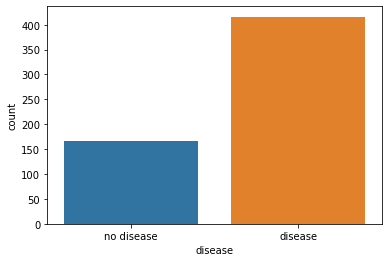

In [11]:
sns.countplot(x=data.disease)
plt.xticks([0, 1],['no disease', 'disease'])
plt.savefig('results/visuals/disease_classes_countplot.png')
plt.show()

**Quantitative variables**

In [12]:
quantitative_descriptive_statistics = data.describe()
display(quantitative_descriptive_statistics)
quantitative_descriptive_statistics.to_excel("results/dataframes/quantitative_variables_descriptive_statistics.xlsx")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,disease
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,0.756432,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,0.713551
std,16.189833,0.429603,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,0.000000
25%,33.000000,1.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,0.000000
50%,45.000000,1.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,1.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,1.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,1.000000


**Categorical variables**
Variables *gender* and *disease* have numerical values, but are categorical meaning. Variable *gender* takes the values 0 (Female) or 1 (Male). Variable *disease* takes the values 1 (patient with liver disease) or 0 (patient with no disease).

In [13]:
categorical = ['gender', 'disease']
quantitative = [el for el in quantitative if not el in categorical]

### Normality tests

#### Null hypothesis: variable x comes from a normal distribution

In [14]:
shapiro_results = [shapiro(data[col].dropna()) for col in quantitative]
shapiro_stats = [result.statistic for result in shapiro_results]
shapiro_pvalue = [result.pvalue for result in shapiro_results]

df_distributed = pd.DataFrame({'variable': quantitative, 'shapiro p-value': shapiro_pvalue})
df_distributed['normally distributed (shapiro)'] = np.where(df_distributed['shapiro p-value'] > 0.05, 'YES', 'NO')

display(df_distributed)
df_distributed.to_excel("results/dataframes/if_variable_is_distributed.xlsx")

,variable,shapiro p-value,normally distributed (shapiro)
0,age,3.676197e-03,NO
1,alkaline_phosphotase,5.217418e-35,NO
2,alamine_aminotransferase,1.402700e-41,NO
3,aspartate_aminotransferase,1.483975e-42,NO
4,total_bilirubin,1.577398e-38,NO
5,direct_bilirubin,1.156318e-36,NO
6,total_protiens,3.712408e-03,NO
7,albumin,6.247303e-03,NO
8,albumin_and_globulin_ratio,1.306171e-13,NO


##### The null hypothesis can be rejected for all variables. According to Shapiro-Wilk test's results, each variable is not normally distributed.

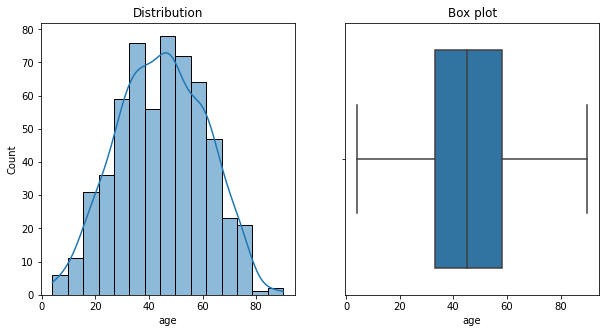

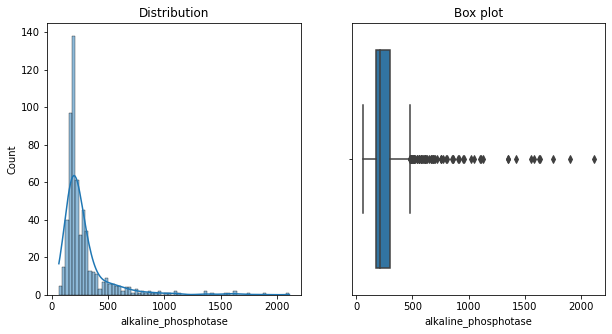

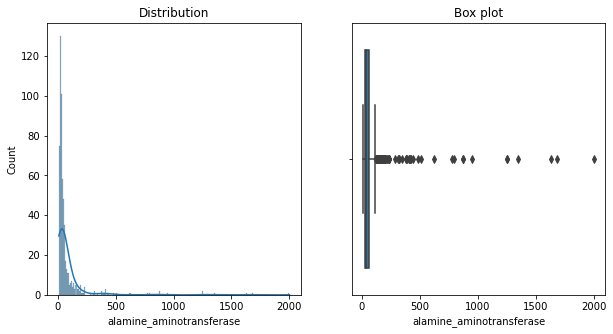

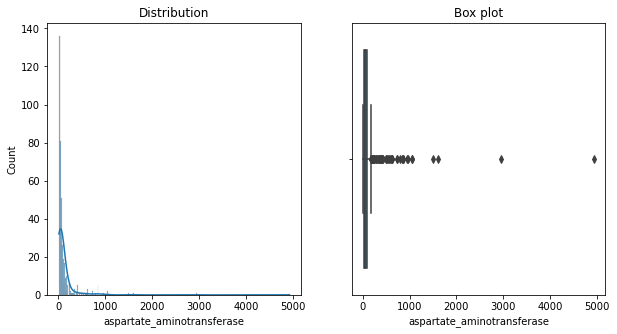

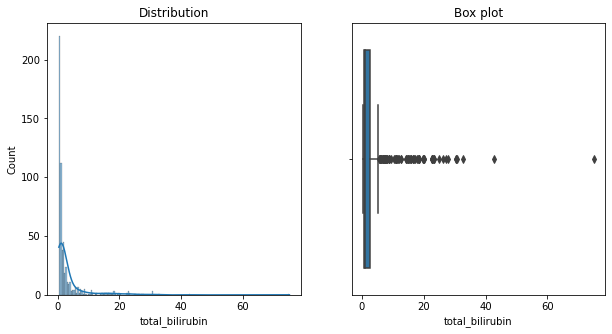

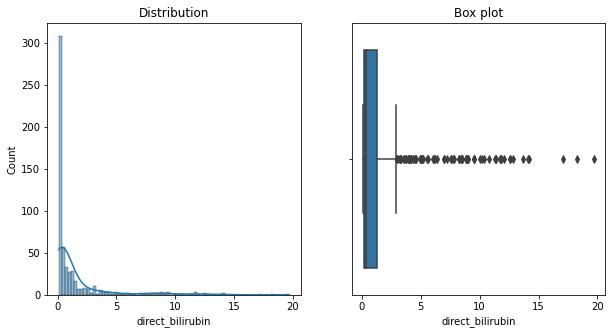

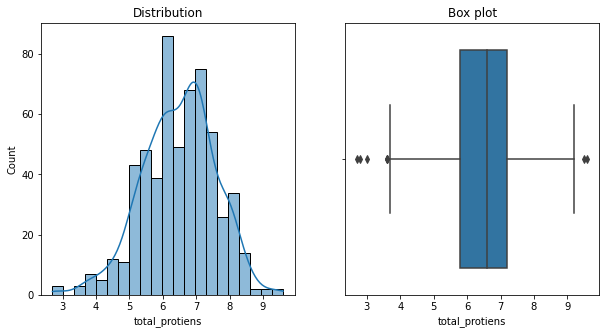

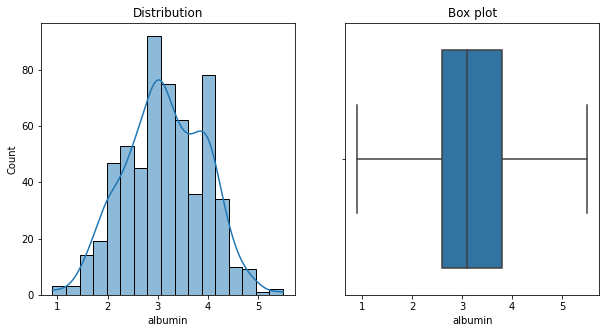

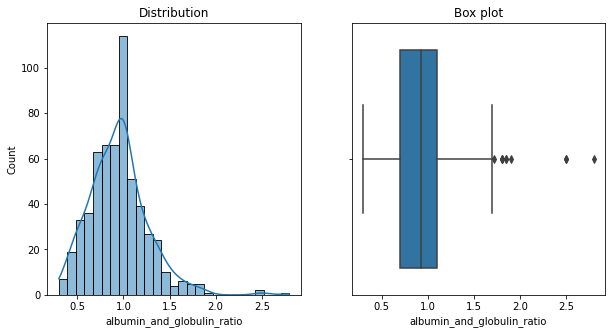

In [15]:
for col in quantitative:
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    sns.histplot(ax=axes[0], data=data, x=col, kde=True)
    sns.boxplot(ax=axes[1], data=data, x=col)
    axes[0].title.set_text('Distribution')
    axes[1].title.set_text('Box plot')
    plt.savefig('results/visuals/distribution_variable_'+col+'.png')
    plt.show()

### Variable correlations

[]

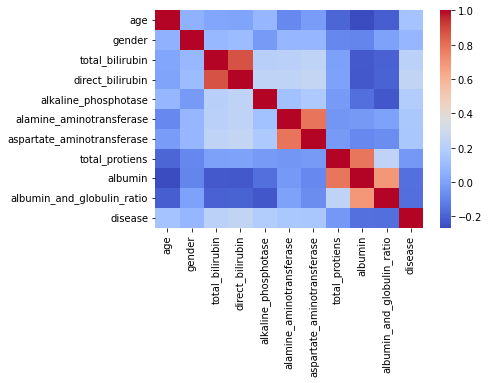

In [16]:
sns.heatmap(data.corr(), cmap="coolwarm")
plt.savefig('results/visuals/variables_correlations_heatmap.png')
plt.plot()

[]

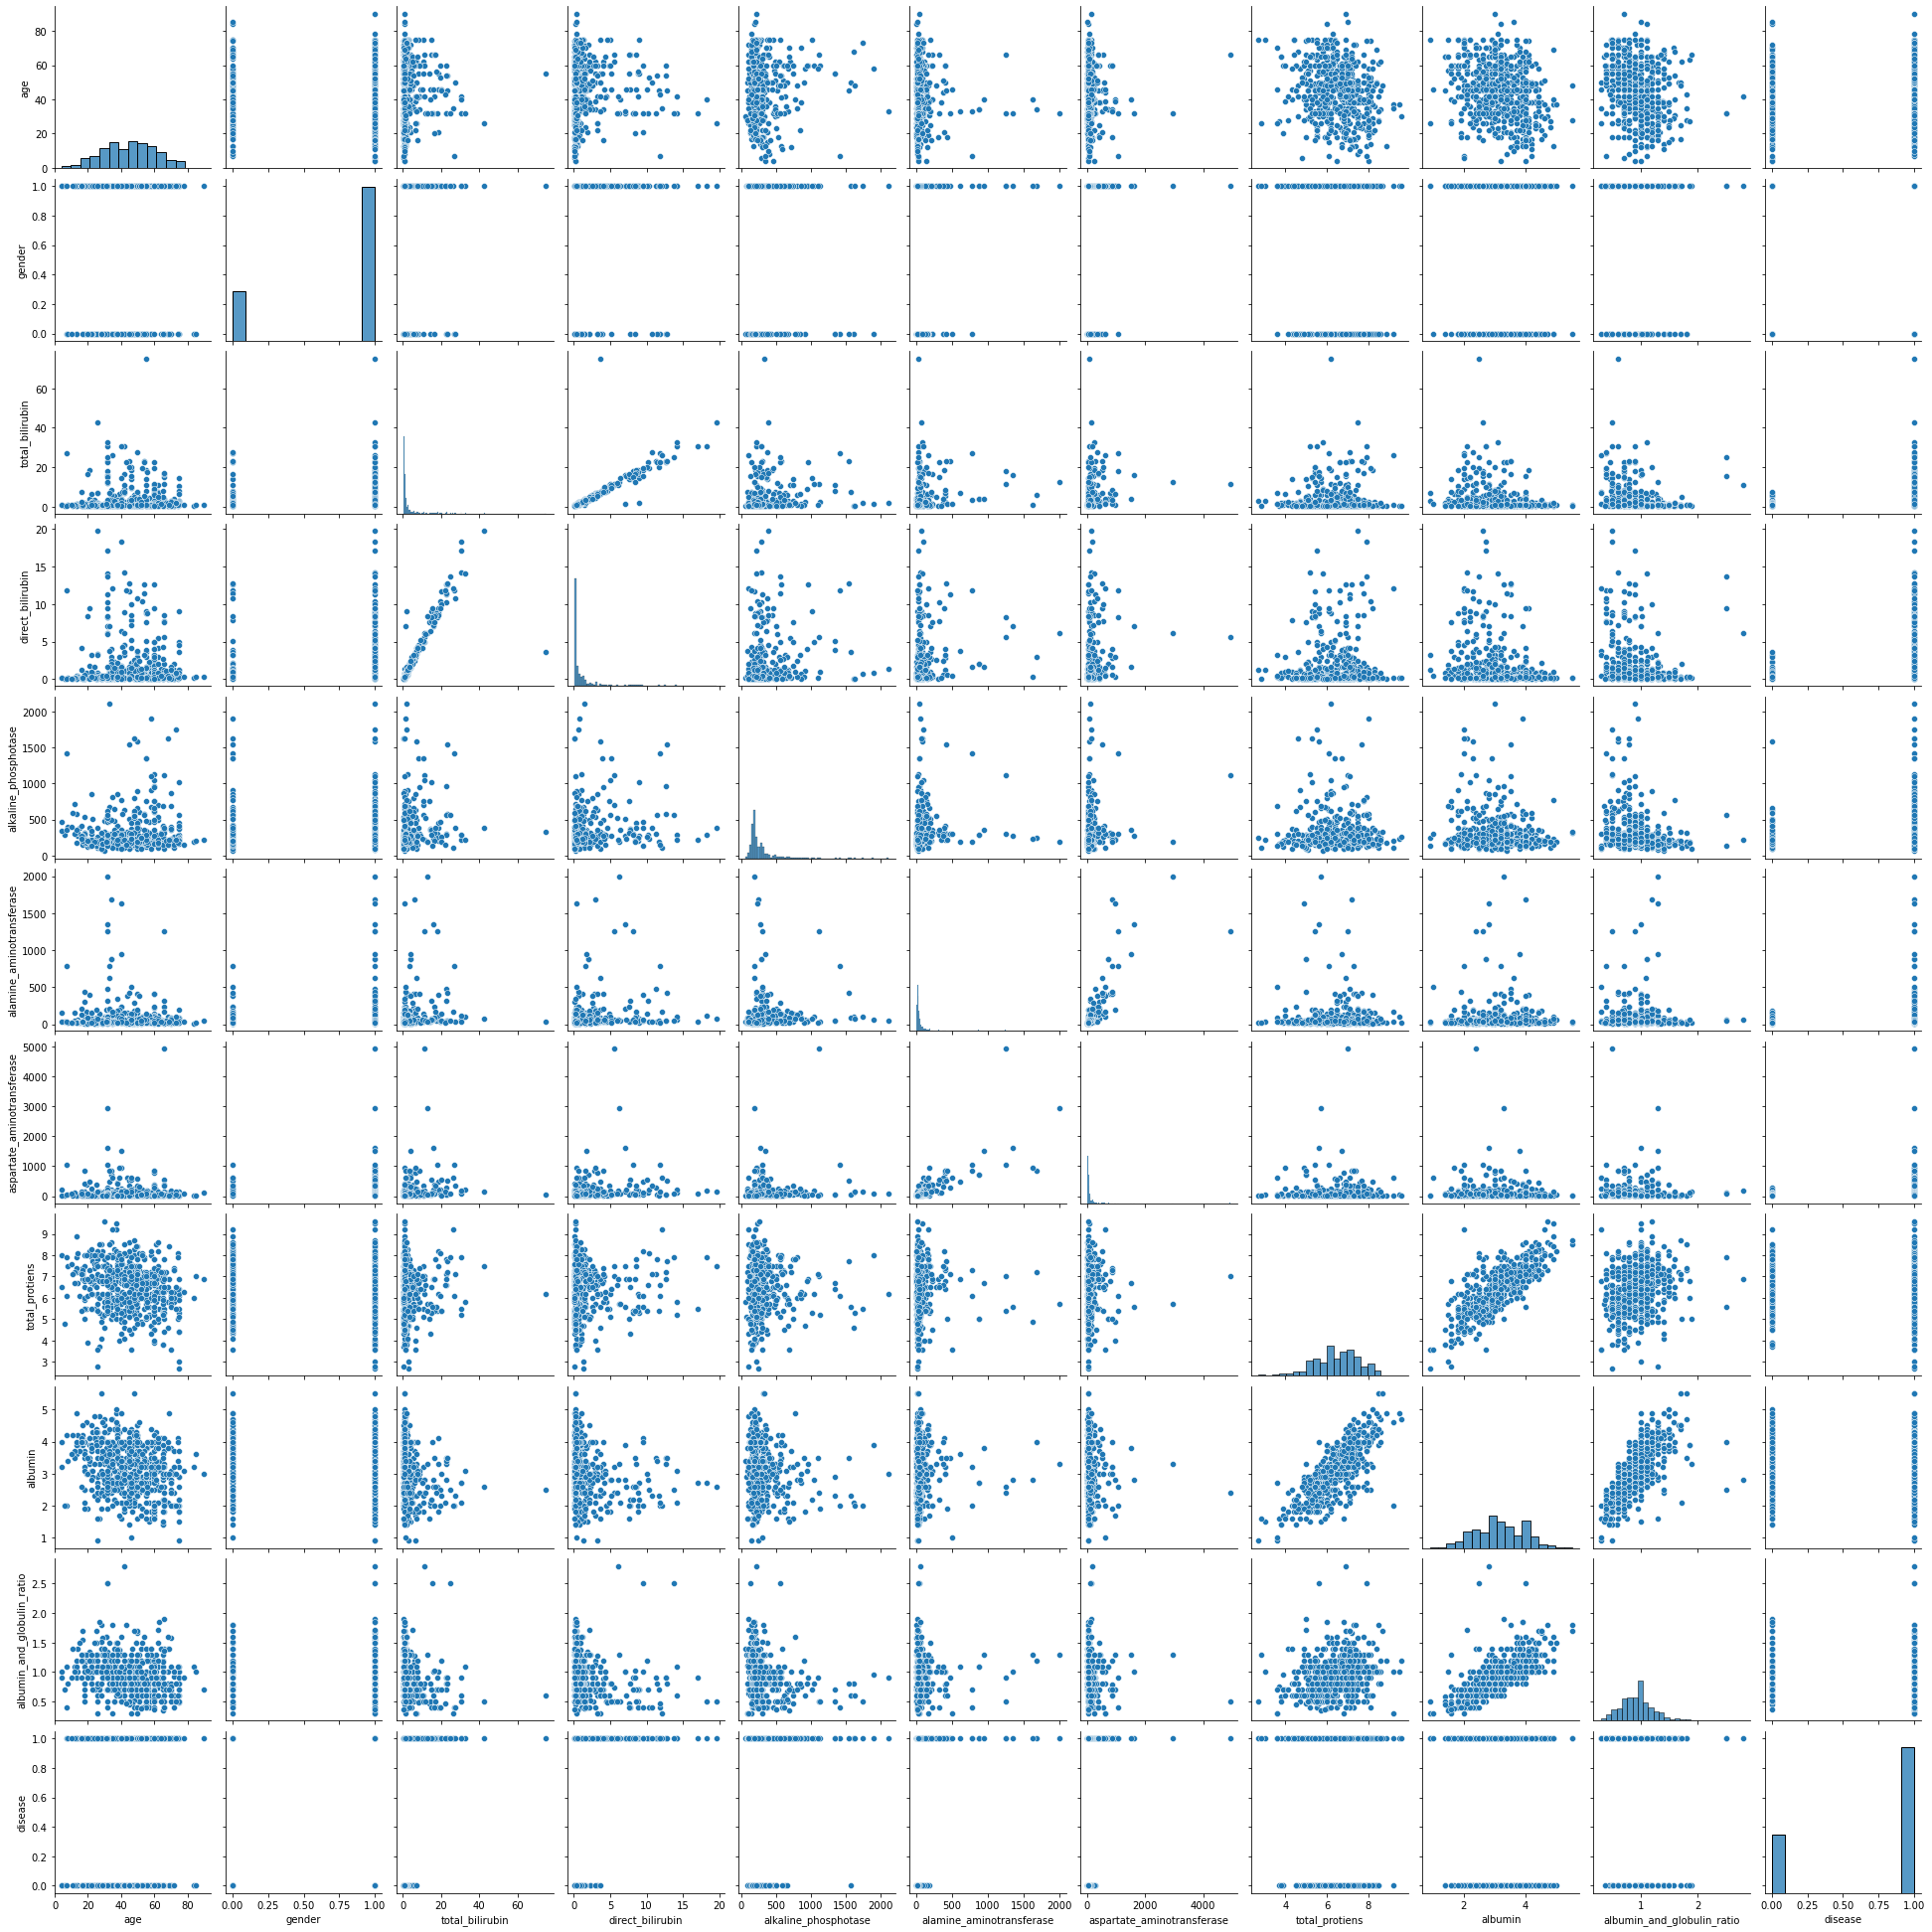

In [17]:
sns.pairplot(data)
plt.savefig('results/visuals/variables_correlations_pairplot.png')
plt.plot()

In [18]:
# Spearman's correlation test
correlation, pvalue = spearmanr(data, nan_policy='omit')

correlation_matrix = {'variable': data.columns}
pvalue_matrix = {'variable': data.columns}
for i in range(len(data.columns)):
    correlation_matrix[data.columns[i]] = correlation[i]
    pvalue_matrix[data.columns[i]] = pvalue[i]

df_pvalue_matrix = pd.DataFrame(pvalue_matrix).set_index('variable')
df_correlation_matrix = pd.DataFrame(correlation_matrix).set_index('variable')

df_pvalue_matrix_styled = df_pvalue_matrix.style.applymap(pval_relevant)
df_correlation_matrix_styled = df_correlation_matrix.style.apply(lambda x: df_pvalue_matrix.applymap(pval_relevant), axis=None)

print(color.BOLD+'pvalues matrix:'+color.END)
display(df_pvalue_matrix_styled)
print(color.BOLD+'correlation statistics matrix:'+color.END)
display(df_correlation_matrix_styled)

df_pvalue_matrix_styled.to_excel("results/dataframes/correlation_pvalue.xlsx")
df_correlation_matrix_styled.to_excel("results/dataframes/correlation_statistic.xlsx")

pvalues matrix:


,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,disease
variable,,,,,,,,,,,
age,0.000000,0.132570,0.005933,0.010093,0.153372,0.102280,0.659511,0.000023,0.000000,0.000000,0.001718
gender,0.132570,0.000000,0.000001,0.000000,0.056192,0.000001,0.000000,0.028181,0.021180,0.833667,0.046693
total_bilirubin,0.005933,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.642722,0.000000,0.000000,0.000000
direct_bilirubin,0.010093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.630081,0.000000,0.000000,0.000000
alkaline_phosphotase,0.153372,0.056192,0.000000,0.000000,0.000000,0.000000,0.000000,0.735371,0.000034,0.000000,0.000000
alamine_aminotransferase,0.102280,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.650356,0.204099,0.045028,0.000000
aspartate_aminotransferase,0.659511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040725,0.000001,0.000000,0.000000
total_protiens,0.000023,0.028181,0.642722,0.630081,0.735371,0.650356,0.040725,0.000000,0.000000,0.000000,0.437459
albumin,0.000000,0.021180,0.000000,0.000000,0.000034,0.204099,0.000001,0.000000,0.000000,0.000000,0.000050


correlation statistics matrix:


,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,disease
variable,,,,,,,,,,,
age,1.000000,0.062364,0.113827,0.106473,0.059205,-0.067737,-0.018285,-0.174271,-0.260791,-0.249951,0.129572
gender,0.062364,1.000000,0.200503,0.209210,0.079131,0.201107,0.209434,-0.090905,-0.095440,-0.008746,0.082416
total_bilirubin,0.113827,0.200503,1.000000,0.959216,0.383794,0.436586,0.508869,-0.019252,-0.222184,-0.285458,0.303879
direct_bilirubin,0.106473,0.209210,0.959216,1.000000,0.367818,0.412322,0.504138,-0.019987,-0.232664,-0.298187,0.297270
alkaline_phosphotase,0.059205,0.079131,0.383794,0.367818,1.000000,0.410752,0.395732,0.014028,-0.170809,-0.321725,0.273247
alamine_aminotransferase,-0.067737,0.201107,0.436586,0.412322,0.410752,1.000000,0.773611,-0.018811,-0.052673,-0.083335,0.290709
aspartate_aminotransferase,-0.018285,0.209434,0.508869,0.504138,0.395732,0.773611,1.000000,-0.084779,-0.204867,-0.209082,0.308897
total_protiens,-0.174271,-0.090905,-0.019252,-0.019987,0.014028,-0.018811,-0.084779,1.000000,0.779077,0.273186,-0.032220
albumin,-0.260791,-0.095440,-0.222184,-0.232664,-0.170809,-0.052673,-0.204867,0.779077,1.000000,0.754140,-0.167079


## Chosen tests

Based on the above tables, it is possible to make a preliminary conclusion which factors have the greatest influence on each other and influence on the possibility of the disease risk.

In order to precisely analyze how each medical test result (variable) affect whether a patient is sick or not, the following tests were performed:
- The influence of the patient's age on the risk of the disease.
- The influence of the patient's gender on the risk of the disease.
- The influence of the patient's age and gender on the risk of the disease.
- The influence of the patient's blood albumin concentration on the risk of the disease.
- The influence of the patient's age, gender and blood albumin concentration on the risk of the disease.
- The influence of the patient's ratio of albumin to globulins in the blood on the risk of the disease.
- The influence of the patient's age, gender, blood albumin concentration and ratio of albumin to globulins on the risk of the disease.
- The influence of the patient's total blood protein concentration on the risk of the disease.
- The relationship between total protein, albumin and albumin-to-globulin ratio variables to each other.
- The influence of the patient's blood total bilirubin concentration on the risk of the disease.
- The influence of the patient's blood direct bilirubin concentration on the risk of the disease.
- The relationship between total bilirubin and direct bilirubin.
- The influence of the patient's alkaline phosphotase level on the risk of the disease.
- The influence of the patient's alamine aminotransferase level on the risk of the disease.
- The influence of the patient's aspartate aminotransferase level on the risk of the disease.
- The influence of individual factors on the risk of the disease depending on the patient's gender.
- The influence of the number of morphotic elements exceeding the specified norm on the risk of disease.
- The relationship between total bilirubin, alkaline phosphotase, alamine aminotransferase and total protiens variables to each other.
- The influence of explanatory variables on the total protein variable.

### The influence of the patient's age on the risk of the disease

,mean,median,min,max,std
,age,age,age,age,age
disease,,,,,
0,41.239521,40,4,85,16.999366
1,46.153846,46,7,90,15.654412


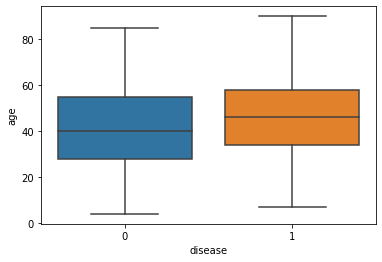

Variance analysis:
H0: The average age does not differ for people with and without disease (m1 = m2).
H1: The average age differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 0.0017743682485203446
The average age for a person with disease 1 is NOT equal to the average age for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.0794 + 0.0191 * age
p = exp( 0.0794 + [0.0191] * ['age']^T ) / 1 + exp( 0.0794 + [0.0191] * ['age']^T )

Coefficient B1=0.0191 means that p increases with the increase of the independent variable age. 
-------------------------------------------------------------------------------------------------------------------


In [19]:
relation_between_numerical_and_categorical(data, 'age', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['age'])

##### There is a statistically significant difference between the mean age of sick people and healthy people. Thus, there is a relation between age and the presence or absence of the disease.

### The influence of the patient's gender on the risk of the disease.

In [20]:
relation_between_categorical_and_categorical(data, 'disease', 'gender')

Chi-squared test:

H0: There is NO relation between the variables
H1: There is a relation between the variables

Cross table:


gender,0,1
disease,,
0,50,117
1,92,324


Chi-square statistic = 3.5466486106706046
p_value = 0.059665846857774464
Variables are independent (H0 holds true).
-------------------------------------------------------------------------------------------------------------------


##### p_value=0.059 is only a little bigger than chosen significance level (0.05), so I decided to analyze it further.

In [21]:
log_reg_test(data, 'disease', ['gender'])

Logistic Regression:

logit(p) = 0.6219 + 0.3921 * gender
p = exp( 0.6219 + [0.3921] * ['gender']^T ) / 1 + exp( 0.6219 + [0.3921] * ['gender']^T )

Coefficient B1=0.3921 means that p increases with the increase of the independent variable gender. 
-------------------------------------------------------------------------------------------------------------------


##### There might be a relation between gender and the presence or absence of the disease.

### The influence of the patient's age and gender on the risk of the disease.

In [22]:
# new column to investigate relations beetween age and groups of patiens described by gender and disease occurrence:
conditions = [(data['gender'] == 0) & (data['disease'] == 0), 
              (data['gender'] == 0) & (data['disease'] == 1),
              (data['gender'] == 1) & (data['disease'] == 0), 
              (data['gender'] == 1) & (data['disease'] == 1)]
values = ['Female_no_disease', 'Female_disease', 'Male_no_disease', 'Male_disease']
data['gender_disease'] = np.select(conditions, values)
data.head()

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,disease,gender_disease
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,Female_disease
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,Male_disease
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,Male_disease
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,Male_disease
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,Male_disease


,mean,median,min,max,std
,age,age,age,age,age
gender_disease,,,,,
Female_disease,43.347826,45.0,7,75,15.409027
Female_no_disease,42.740000,39.5,17,85,16.917338
Male_disease,46.950617,47.0,12,90,15.655265
Male_no_disease,40.598291,40.0,4,72,17.066331


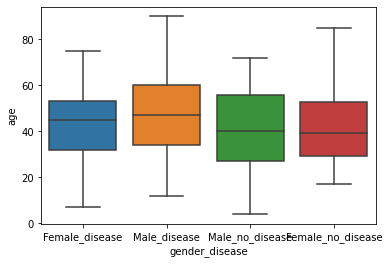

Variance analysis:
H0: The average age do not differ (m_1 = m_2 = ... = m_n).
H1: The average age differ (m_i =/= m_j).

Kruskal-Wallis H-test:
p_value = 0.004799370675015098
gender_disease: ['Female_disease' 'Male_disease' 'Male_no_disease' 'Female_no_disease'] DO NOT all have the same average age. Thus, age effects the value of gender_disease.
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
   Female_disease Female_no_disease  -0.6078 0.9964 -7.8595  6.6438  False
   Female_disease      Male_disease   3.6028 0.2275 -1.2731  8.4787  False
   Female_disease   Male_no_disease  -2.7495 0.6069 -8.5007  3.0017  False
Female_no_disease      Male_disease   4.2106  0.309 -2.0606 10.4818  False
Female_no_disease   Male_no_disease  -2.1417 0.8584 -9.1152  4.8318  False
     Male_disease   Male_no_disease  -6.3523 0.0015 

In [23]:
relation_between_numerical_and_categorical(data, 'age', 'gender_disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['age','gender'])

##### There is a statistically significant difference between the mean age of sick men and healthy men and no difference between the mean age of sick women and healthy women. Thus, there is an influence of gender on the relation between age and the presence or absence of the disease.

### The influence of the patient's blood albumin concentration on the risk of the disease.

,mean,median,min,max,std
,albumin,albumin,albumin,albumin,albumin
disease,,,,,
0,3.344311,3.4,1.4,5.0,0.783690
1,3.060577,3.0,0.9,5.5,0.786595


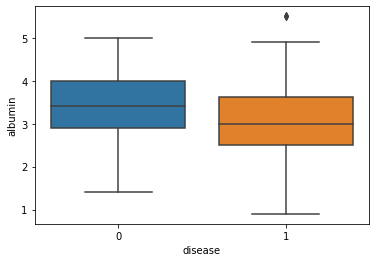

Variance analysis:
H0: The average albumin does not differ for people with and without disease (m1 = m2).
H1: The average albumin differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 5.567003967829314e-05
The average albumin for a person with disease 1 is NOT equal to the average albumin for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 2.3711 + -0.4554 * albumin
p = exp( 2.3711 + [-0.4554] * ['albumin']^T ) / 1 + exp( 2.3711 + [-0.4554] * ['albumin']^T )

Coefficient B1=-0.4554 means that p decreases with the increase of the independent variable albumin. 
-------------------------------------------------------------------------------------------------------------------


In [24]:
relation_between_numerical_and_categorical(data, 'albumin', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['albumin'])

##### There is a statistically significant difference between the mean blood albumin concentration of sick people and healthy people. Thus, there is a relation between blood albumin concentration and the presence or absence of the disease.

### The influence of the patient's age, gender and blood albumin concentration on the risk of the disease.

,mean,median,min,max,std
,albumin,albumin,albumin,albumin,albumin
gender_disease,,,,,
Female_disease,3.231522,3.30,1.0,5.5,0.839012
Female_no_disease,3.350000,3.25,1.4,4.9,0.810706
Male_disease,3.012037,3.00,0.9,5.5,0.765476
Male_no_disease,3.341880,3.50,1.4,5.0,0.775402


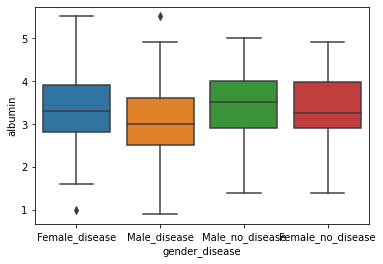

Variance analysis:
H0: The average albumin do not differ (m_1 = m_2 = ... = m_n).
H1: The average albumin differ (m_i =/= m_j).

Kruskal-Wallis H-test:
p_value = 4.5141118168261804e-05
gender_disease: ['Female_disease' 'Male_disease' 'Male_no_disease' 'Female_no_disease'] DO NOT all have the same average albumin. Thus, albumin effects the value of gender_disease.
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
   Female_disease Female_no_disease   0.1185  0.825 -0.2361  0.4731  False
   Female_disease      Male_disease  -0.2195 0.0837 -0.4579  0.0189  False
   Female_disease   Male_no_disease   0.1104  0.743 -0.1709  0.3916  False
Female_no_disease      Male_disease   -0.338 0.0241 -0.6446 -0.0313   True
Female_no_disease   Male_no_disease  -0.0081 0.9999 -0.3491  0.3329  False
     Male_disease   Male_no_diseas

In [25]:
# Relation between blood albumin concentration and gender - disease groups
relation_between_numerical_and_categorical(data, 'albumin', 'gender_disease', alpha=0.05, normal_dist=False)
# Relation between blood albumin concentration and age
relation_between_numerical_and_numerical(data,'age','albumin',normal_dist=False)

# Influence of the age, gender and blood albumin concentration on the risk of the disease.
log_reg_test(data, 'disease', ['age','gender','albumin'])

##### There is a statistically significant difference between the mean blood albumin concentration of sick men and healthy men and no difference between the mean blood albumin concentration of sick women and healthy women. Thus, there is an influence of gender on the relation between blood albumin concentration and the presence or absence of the disease. In addition, there is a weak influence of age on blood albumin concentration - increasing age results in decreasing in albumin concentration, which results in increasing risk of a disease.
##### Based on regression results, value of blood albumin concentration or patient's gender has stronger influence on the risk of disease than the patient's age BUT age has influence of albumin concentration.

### The influence of the patient's ratio of albumin to globulins in the blood on the risk of the disease.

In [26]:
print('Original data:')
display(data.isnull().sum())
# There are 4 missing values in 'albumin_and_globulin_ratio' column, so I created temporary data frame without those 4 rows.
temp = data.loc[:,:].dropna()
print('Data without NANs:')
display(temp.isnull().sum())

Original data:


age                           0
gender                        0
total_bilirubin               0
direct_bilirubin              0
alkaline_phosphotase          0
alamine_aminotransferase      0
aspartate_aminotransferase    0
total_protiens                0
albumin                       0
albumin_and_globulin_ratio    4
disease                       0
gender_disease                0
dtype: int64

Data without NANs:


age                           0
gender                        0
total_bilirubin               0
direct_bilirubin              0
alkaline_phosphotase          0
alamine_aminotransferase      0
aspartate_aminotransferase    0
total_protiens                0
albumin                       0
albumin_and_globulin_ratio    0
disease                       0
gender_disease                0
dtype: int64

,mean,median,min,max,std
,albumin_and_globulin_ratio,albumin_and_globulin_ratio,albumin_and_globulin_ratio,albumin_and_globulin_ratio,albumin_and_globulin_ratio
disease,,,,,
0,1.029576,1.0,0.37,1.9,0.287252
1,0.914179,0.9,0.30,2.8,0.326153


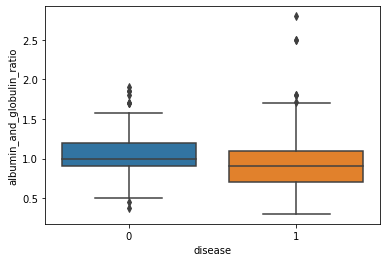

Variance analysis:
H0: The average albumin_and_globulin_ratio does not differ for people with and without disease (m1 = m2).
H1: The average albumin_and_globulin_ratio differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 5.812072226507183e-06
The average albumin_and_globulin_ratio for a person with disease 1 is NOT equal to the average albumin_and_globulin_ratio for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 1.9113 + -1.0251 * albumin_and_globulin_ratio
p = exp( 1.9113 + [-1.0251] * ['albumin_and_globulin_ratio']^T ) / 1 + exp( 1.9113 + [-1.0251] * ['albumin_and_globulin_ratio']^T )

Coefficient B1=-1.0251 means that p decreases with the increase of the independent variable albumin_and_globulin_ratio. 
-------------------------------------------------------------------------------------------------------------------


In [27]:
relation_between_numerical_and_categorical(temp, 'albumin_and_globulin_ratio', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(temp, 'disease', ['albumin_and_globulin_ratio'])

##### There is a statistically significant difference between the mean albumin-to-globulin ratio of sick people and healthy people. Thus, there is a relation between patient's ratio of albumin to globulins in the blood and the presence or absence of the disease.

### The influence of the patient's age, gender, blood albumin concentration and ratio of albumin to globulins on the risk of the disease.

In [28]:
relation_stats(temp,['age','albumin','albumin_and_globulin_ratio'],['gender','disease'],if_transpose=True)
log_reg_test(temp, 'disease', ['age','gender','albumin','albumin_and_globulin_ratio'])

gender                                     0                     1           
disease                                    0          1          0          1
mean   age                         42.897959  43.329670  40.715517  46.938080
       albumin                      3.363265   3.224176   3.329310   3.011765
       albumin_and_globulin_ratio   1.007347   0.917582   1.038966   0.913220
median age                         41.000000  45.000000  40.500000  47.000000
       albumin                      3.300000   3.300000   3.450000   3.000000
       albumin_and_globulin_ratio   1.000000   0.900000   1.000000   0.900000
min    age                         17.000000   7.000000   4.000000  12.000000
       albumin                      1.400000   1.000000   1.400000   0.900000
       albumin_and_globulin_ratio   0.450000   0.300000   0.370000   0.300000
max    age                         85.000000  75.000000  72.000000  90.000000
       albumin                      4.900000   5.500000   5.000000   5.500000
       albumin_and_globulin_ratio   1.800000   1.800000   1.900000   2.800000
std    age                         17.055357  15.493407  17.092997  15.677927
       albumin                      0.813607   0.840680   0.766700   0.766648
       albumin_and_globulin_ratio   0.283187   0.287322   0.289655   0.336689

Logistic Regression:

logit(p) = 1.3298 + 0.0132 * age + 0.3434 * gender + -0.1999 * albumin + -0.6211 * albumin_and_globulin_ratio
p = exp( 1.3298 + [ 0.0132  0.3434 -0.1999 -0.6211] * ['age', 'gender', 'albumin', 'albumin_and_globulin_ratio']^T ) / 1 + exp( 1.3298 + [ 0.0132  0.3434 -0.1999 -0.6211] * ['age', 'gender', 'albumin', 'albumin_and_globulin_ratio']^T )

Coefficient B1=0.0132 means that p increases with the increase of the independent variable age. 
Coefficient B2=0.3434 means that p increases with the increase of the independent variable gender. 
Coefficient B3=-0.1999 means that p decreases with the increase of the independent variable albumin. 
Coefficient B4=-0.6211 means that p decreases with the increase of the independent variable albumin_and_globulin_ratio. 
-------------------------------------------------------------------------------------------------------------------


##### Based on regression results, value of ratio of albumin to globulins has stronger influence on the risk of disease than patient's age, gender or blood albumin concentration.

### The influence of the patient's total blood protein concentration on the risk of the disease.  

,mean,median,min,max,std
,total_protiens,total_protiens,total_protiens,total_protiens,total_protiens
disease,,,,,
0,6.543114,6.60,3.7,9.2,1.063042
1,6.459135,6.55,2.7,9.6,1.094659


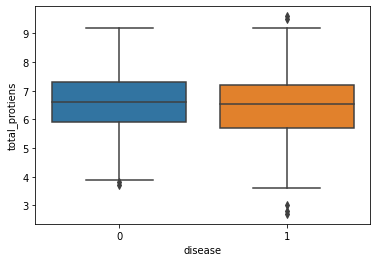

Variance analysis:
H0: The average total_protiens does not differ for people with and without disease (m1 = m2).
H1: The average total_protiens differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 0.43714664759243915
The average total_protiens for a person with disease 1 is equal to the average total_protiens for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------


In [29]:
relation_between_numerical_and_categorical(data, 'total_protiens', 'disease', alpha=0.05, normal_dist=False)

##### The variable total_protiens is not statistically significant, it does not affect the dependent variable disease.

### The relationship between total protein, albumin and albumin-to-globulin ratio variables to each other.  

[]

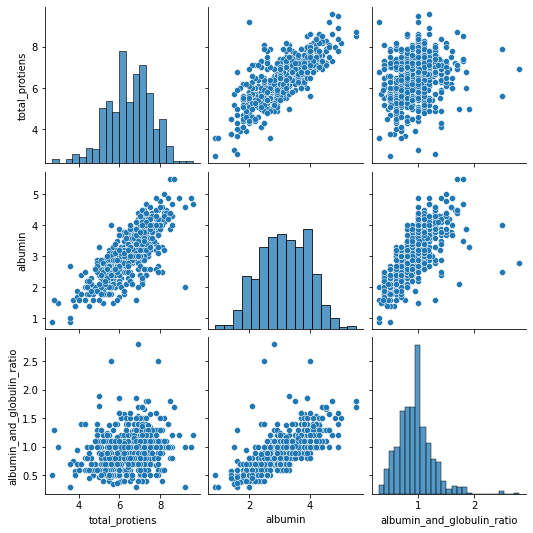

In [30]:
sns.pairplot(temp[['total_protiens','albumin','albumin_and_globulin_ratio']])
plt.plot()

In [31]:
relation_between_numerical_and_numerical(temp,'total_protiens','albumin',normal_dist=False)
relation_between_numerical_and_numerical(temp,'total_protiens','albumin_and_globulin_ratio',normal_dist=False)
relation_between_numerical_and_numerical(temp,'albumin','albumin_and_globulin_ratio',normal_dist=False)

Spearman correlation:

H0: There is NO relation between the variables total_protiens and albumin
H1: There is a relation between the variables total_protiens and albumin

pvalue = 8.16321629340798e-119
There is a relation between the variables total_protiens and albumin, statistic = 0.7785. Thus, albumin increases with the increase of total_protiens. 
-------------------------------------------------------------------------------------------------------------------
Spearman correlation:

H0: There is NO relation between the variables total_protiens and albumin_and_globulin_ratio
H1: There is a relation between the variables total_protiens and albumin_and_globulin_ratio

pvalue = 2.2789943978281823e-11
There is a relation between the variables total_protiens and albumin_and_globulin_ratio, statistic = 0.2732. Thus, albumin_and_globulin_ratio increases with the increase of total_protiens. 
---------------------------------------------------------------------------------------------------

##### There is a strong relationship between total protein, albumin and albumin-to-globulin ratio variables to each other.  
##### Based on the tests, there are no statistically significant differences in the average values of total protein in the blood between healthy people and sick people, so there is no effect of protein on the presence or absence of the disease. However, it is necessary during the examination of the patient - it affects the value of albumin and the ratio of albumin to globulin.

### The influence of the patient's blood total bilirubin concentration on the risk of the disease.

,mean,median,min,max,std
,total_bilirubin,total_bilirubin,total_bilirubin,total_bilirubin,total_bilirubin
disease,,,,,
0,1.142515,0.8,0.5,7.3,1.004472
1,4.164423,1.4,0.4,75.0,7.144831


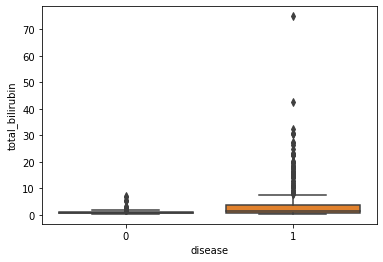

Variance analysis:
H0: The average total_bilirubin does not differ for people with and without disease (m1 = m2).
H1: The average total_bilirubin differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 2.2895189552050415e-13
The average total_bilirubin for a person with disease 1 is NOT equal to the average total_bilirubin for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.085 + 0.4842 * total_bilirubin
p = exp( 0.085 + [0.4842] * ['total_bilirubin']^T ) / 1 + exp( 0.085 + [0.4842] * ['total_bilirubin']^T )

Coefficient B1=0.4842 means that p increases with the increase of the independent variable total_bilirubin. 
-------------------------------------------------------------------------------------------------------------------


In [32]:
relation_between_numerical_and_categorical(data, 'total_bilirubin', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['total_bilirubin'])

##### There is quite a strong relationship between the value of total_bilirubin and the risk of the disease.

### The influence of the patient's blood direct bilirubin concentration on the risk of the disease.

,mean,median,min,max,std
,direct_bilirubin,direct_bilirubin,direct_bilirubin,direct_bilirubin,direct_bilirubin
disease,,,,,
0,0.396407,0.2,0.1,3.6,0.519255
1,1.923558,0.5,0.1,19.7,3.206901


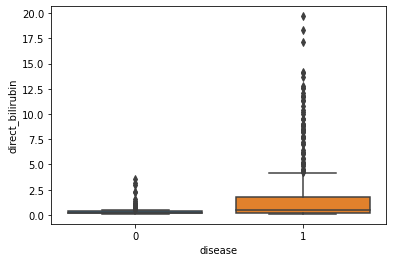

Variance analysis:
H0: The average direct_bilirubin does not differ for people with and without disease (m1 = m2).
H1: The average direct_bilirubin differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 7.431125887985509e-13
The average direct_bilirubin for a person with disease 1 is NOT equal to the average direct_bilirubin for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.2651 + 0.9056 * direct_bilirubin
p = exp( 0.2651 + [0.9056] * ['direct_bilirubin']^T ) / 1 + exp( 0.2651 + [0.9056] * ['direct_bilirubin']^T )

Coefficient B1=0.9056 means that p increases with the increase of the independent variable direct_bilirubin. 
-------------------------------------------------------------------------------------------------------------------


In [33]:
relation_between_numerical_and_categorical(data, 'direct_bilirubin', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['direct_bilirubin'])

##### There is a very strong relationship between the value of direct_bilirubin and the risk of the disease.

### The relationship between total bilirubin and direct bilirubin.

[]

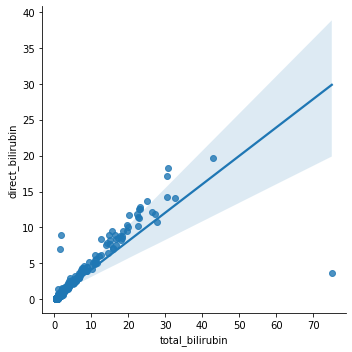

In [34]:
sns.lmplot(data=data,x='total_bilirubin',y='direct_bilirubin')
plt.plot()

In [35]:
relation_between_numerical_and_numerical(data,'total_bilirubin','direct_bilirubin',normal_dist=False)
lin_reg_test(data, 'direct_bilirubin', ['total_bilirubin'])

Spearman correlation:

H0: There is NO relation between the variables total_bilirubin and direct_bilirubin
H1: There is a relation between the variables total_bilirubin and direct_bilirubin

pvalue = 5.425e-321
There is a relation between the variables total_bilirubin and direct_bilirubin, statistic = 0.9592. Thus, direct_bilirubin increases with the increase of total_bilirubin. 
-------------------------------------------------------------------------------------------------------------------
Linear Regression:

y = 0.1812 + 0.3956 * total_bilirubin
Coefficient B1=0.3956 means that direct_bilirubin increases with the increase of the independent variable total_bilirubin. 

Coefficient of determination R^2 = 0.765 means that the explanatory variables explain the explanatory variable direct_bilirubin well.
-------------------------------------------------------------------------------------------------------------------


##### There is a strong relationship between the value of total_bilirubin and the value of direct_bilirubin.

### The influence of the patient's alkaline phosphotase level on the risk of the disease.

,mean,median,min,max,std
,alkaline_phosphotase,alkaline_phosphotase,alkaline_phosphotase,alkaline_phosphotase,alkaline_phosphotase
disease,,,,,
0,219.754491,186,90,1580,140.986262
1,319.007212,229,63,2110,268.307911


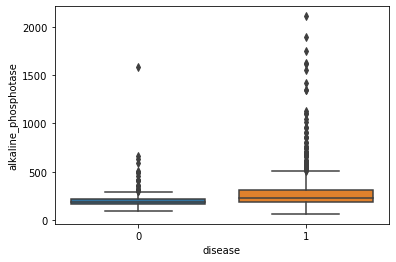

Variance analysis:
H0: The average alkaline_phosphotase does not differ for people with and without disease (m1 = m2).
H1: The average alkaline_phosphotase differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 4.3472343156702066e-11
The average alkaline_phosphotase for a person with disease 1 is NOT equal to the average alkaline_phosphotase for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.0 + 0.0036 * alkaline_phosphotase
p = exp( 0.0 + [0.0036] * ['alkaline_phosphotase']^T ) / 1 + exp( 0.0 + [0.0036] * ['alkaline_phosphotase']^T )

Coefficient B1=0.0036 means that p increases with the increase of the independent variable alkaline_phosphotase. 
-------------------------------------------------------------------------------------------------------------------


In [36]:
relation_between_numerical_and_categorical(data, 'alkaline_phosphotase', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['alkaline_phosphotase'])

##### There is a relationship between the value of alkaline_phosphotase and the risk of the disease.

### The influence of the patient's alamine aminotransferase level on the risk of the disease.

,mean,median,min,max,std
,alamine_aminotransferase,alamine_aminotransferase,alamine_aminotransferase,alamine_aminotransferase,alamine_aminotransferase
disease,,,,,
0,33.652695,27,10,181,25.060392
1,99.605769,41,12,2000,212.768472


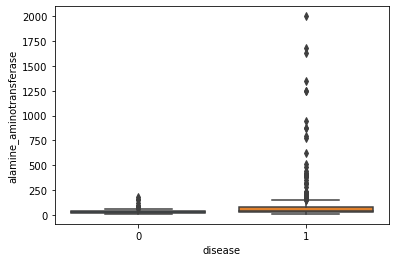

Variance analysis:
H0: The average alamine_aminotransferase does not differ for people with and without disease (m1 = m2).
H1: The average alamine_aminotransferase differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 2.3329351382416684e-12
The average alamine_aminotransferase for a person with disease 1 is NOT equal to the average alamine_aminotransferase for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.0001 + 0.0203 * alamine_aminotransferase
p = exp( 0.0001 + [0.0203] * ['alamine_aminotransferase']^T ) / 1 + exp( 0.0001 + [0.0203] * ['alamine_aminotransferase']^T )

Coefficient B1=0.0203 means that p increases with the increase of the independent variable alamine_aminotransferase. 
-------------------------------------------------------------------------------------------------------------------


In [37]:
relation_between_numerical_and_categorical(data, 'alamine_aminotransferase', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['alamine_aminotransferase'])

##### There is a relationship between the value of alamine_aminotransferase and the risk of the disease but based on the logistic regresion

### The influence of the patient's aspartate aminotransferase level on the risk of the disease.

,mean,median,min,max,std
,aspartate_aminotransferase,aspartate_aminotransferase,aspartate_aminotransferase,aspartate_aminotransferase,aspartate_aminotransferase
disease,,,,,
0,40.688623,29.0,10,285,36.41162
1,137.699519,52.5,11,4929,337.38998


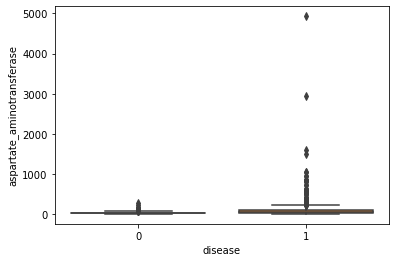

Variance analysis:
H0: The average aspartate_aminotransferase does not differ for people with and without disease (m1 = m2).
H1: The average aspartate_aminotransferase differs for people with and without disease (m1 =/= m2).

Mann-Whitney U rank test:
p_value = 9.209662449089351e-14
The average aspartate_aminotransferase for a person with disease 1 is NOT equal to the average aspartate_aminotransferase for a person with disease 0.
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = 0.079 + 0.0145 * aspartate_aminotransferase
p = exp( 0.079 + [0.0145] * ['aspartate_aminotransferase']^T ) / 1 + exp( 0.079 + [0.0145] * ['aspartate_aminotransferase']^T )

Coefficient B1=0.0145 means that p increases with the increase of the independent variable aspartate_aminotransferase. 
-------------------------------------------------------------------------------------------------------------------


In [38]:
relation_between_numerical_and_categorical(data, 'aspartate_aminotransferase', 'disease', alpha=0.05, normal_dist=False)
log_reg_test(data, 'disease', ['aspartate_aminotransferase'])

##### There is a relationship between the value of aspartate_aminotransferase and the risk of the disease but based on the logistic regresion

### The influence of individual factors on the risk of the disease depending on the patient's gender.

In [39]:
for var in ['total_bilirubin','direct_bilirubin','alkaline_phosphotase','alamine_aminotransferase',
            'aspartate_aminotransferase','total_protiens','albumin','albumin_and_globulin_ratio']:
    print(color.BOLD+color.UNDERLINE+var.upper()+color.END)
    relation_between_numerical_and_categorical(data, var, 'gender_disease', alpha=0.05, normal_dist=False, if_stats=False, if_graph=False)

TOTAL_BILIRUBIN
Variance analysis:
H0: The average total_bilirubin do not differ (m_1 = m_2 = ... = m_n).
H1: The average total_bilirubin differ (m_i =/= m_j).

Kruskal-Wallis H-test:
p_value = 1.4240838187968384e-15
gender_disease: ['Female_disease' 'Male_disease' 'Male_no_disease' 'Female_no_disease'] DO NOT all have the same average total_bilirubin. Thus, total_bilirubin effects the value of gender_disease.
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
   Female_disease Female_no_disease  -2.1864  0.169 -4.9264  0.5537  False
   Female_disease      Male_disease   1.3764 0.2187 -0.4659  3.2188  False
   Female_disease   Male_no_disease  -1.8488 0.1266 -4.0219  0.3243  False
Female_no_disease      Male_disease   3.5628 0.0007  1.1933  5.9324   True
Female_no_disease   Male_no_disease   0.3376 0.9876 -2.2974  

##### Depending on the patient's gender, the following factors influence the risk of the disease:
- There is a statistically significant difference in the average values of total bilirubin between healthy men and sick men.
- There is a statistically significant difference in the average values of direct bilirubin between healthy men and sick men.
- There is a statistically significant difference in the average values of alkaline phosphotase between healthy people and sick people (both women and men).
- There is a statistically significant difference in the average values of alamine aminotransferase between healthy men and sick men.
- There is a statistically significant difference in the average values of aspartate aminotransferase between healthy men and sick men.
- There is a statistically significant difference in the average values of albumin between healthy men and sick men.

##### Following factors do not influence the risk of the disease:
- total protiens
- albumin to globulin ratio

##### In conclusion, depending on the patient's gender, it is important to analyze different features. If a patient is a male, tests can include examining total bilirubin, direct bilirubin, alkaline phosphotase, alamine aminotransferase, aspartate aminotransferase and albumin. On the other hand, for females, only the results of alkaline phosphotase tests can provide information about the risk of the disease.

### The influence of the number of morphotic elements exceeding the specified norm on the risk of disease.

#### Normal Results:
- Total Bilirubin: 0.1 to 1.2 ([source](https://www.mountsinai.org/health-library/tests/bilirubin-blood-test))
- Direct Bilirubin: less than 0.3 ([source](https://www.mountsinai.org/health-library/tests/bilirubin-blood-test))
- Alkaline Phosphotase: 44 to 147 ([source](https://www.ucsfhealth.org/medical-tests/alp-blood-test))
- Alamine Aminotransferase: 4 to 36 ([source](https://www.ucsfhealth.org/medical-tests/alanine-transaminase-(alt)-blood-test))
- Aspartate Aminotransferase: 8 to 33 ([source](https://www.ucsfhealth.org/medical-tests/aspartate-aminotransferase-(ast)-blood-test))
- Total Protiens: 6.0 to 8.3 ([source](https://www.mountsinai.org/health-library/tests/total-protein))
- Albumin: 3.4 to 5.4 ([source](https://www.ucsfhealth.org/medical-tests/albumin-blood-(serum)-test))
- Albumin and Globulin Ratio: 0.8 to 2.0 ([source](https://healthmatters.io/understand-blood-test-results/albumin-globulin-ratio))

In [40]:
morphotic_elements = data.loc[:,('age','gender')]
morphotic_elements['t_b'] = np.where((0.1<=data['total_bilirubin']) & (data['total_bilirubin']<=1.2), 0, 1)
morphotic_elements['d_b'] = np.where((data['direct_bilirubin']<0.3), 1, 0)
morphotic_elements['a_p'] = np.where((44<=data['alkaline_phosphotase']) & (data['alkaline_phosphotase']<=147), 0, 1)
morphotic_elements['al_a'] = np.where((4<=data['alamine_aminotransferase']) & (data['alamine_aminotransferase']<=36), 0, 1)
morphotic_elements['as_a'] = np.where((8<=data['aspartate_aminotransferase']) & (data['aspartate_aminotransferase']<=33), 0, 1)
morphotic_elements['t_p'] = np.where((6<=data['total_protiens']) & (data['total_protiens']<=8.3), 0, 1)
morphotic_elements['a'] = np.where((3.4<=data['albumin']) & (data['albumin']<=5.4), 0, 1)
morphotic_elements['a_g_ratio'] = np.where((0.8<=data['albumin_and_globulin_ratio']) & (data['albumin_and_globulin_ratio']<=2), 0, 1)
morphotic_elements['num_el_out_norm'] = morphotic_elements[['t_b','d_b','a_p','al_a','as_a','t_p','a','a_g_ratio']].sum(axis=1)
morphotic_elements['disease'] = data.loc[:,'disease']
morphotic_elements.head()

,age,gender,t_b,d_b,a_p,al_a,as_a,t_p,a,a_g_ratio,num_el_out_norm,disease
0,65,0,0,1,1,0,0,0,1,0,3,1
1,62,1,1,0,1,1,1,0,1,1,6,1
2,62,1,1,0,1,1,1,0,1,0,5,1
3,58,1,0,0,1,0,0,0,0,0,1,1
4,72,1,1,0,1,0,1,0,1,1,5,1


In [41]:
relation_between_categorical_and_categorical(morphotic_elements, 'num_el_out_norm', 'disease')
log_reg_test(morphotic_elements, 'disease', ['num_el_out_norm'])

Chi-squared test:

H0: There is NO relation between the variables
H1: There is a relation between the variables

Cross table:


disease,0,1
num_el_out_norm,,
0,2,2
1,13,15
2,40,48
3,39,59
4,34,89
5,22,77
6,14,100
7,3,26


Chi-square statistic = 45.09770480313057
p_value = 1.309158308391657e-07
Variables are dependent (reject H0). Variable num_el_out_norm has influene on variable disease
-------------------------------------------------------------------------------------------------------------------
Logistic Regression:

logit(p) = -0.5692 + 0.3842 * num_el_out_norm
p = exp( -0.5692 + [0.3842] * ['num_el_out_norm']^T ) / 1 + exp( -0.5692 + [0.3842] * ['num_el_out_norm']^T )

Coefficient B1=0.3842 means that p increases with the increase of the independent variable num_el_out_norm. 
-------------------------------------------------------------------------------------------------------------------


##### The more enzymes out of the norm, the greater chance that the patient is sick.

#### The relationship between total bilirubin, alkaline phosphotase, alamine aminotransferase and total protiens variables to each other.

In [42]:
variables = ['total_bilirubin','alkaline_phosphotase','alamine_aminotransferase','total_protiens']
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        relation_between_numerical_and_numerical(data, variables[i], variables[j],normal_dist=False)

Spearman correlation:

H0: There is NO relation between the variables total_bilirubin and alkaline_phosphotase
H1: There is a relation between the variables total_bilirubin and alkaline_phosphotase

pvalue = 6.730501404707823e-22
There is a relation between the variables total_bilirubin and alkaline_phosphotase, statistic = 0.3838. Thus, alkaline_phosphotase increases with the increase of total_bilirubin. 
-------------------------------------------------------------------------------------------------------------------
Spearman correlation:

H0: There is NO relation between the variables total_bilirubin and alamine_aminotransferase
H1: There is a relation between the variables total_bilirubin and alamine_aminotransferase

pvalue = 1.573234017360877e-28
There is a relation between the variables total_bilirubin and alamine_aminotransferase, statistic = 0.4366. Thus, alamine_aminotransferase increases with the increase of total_bilirubin. 
------------------------------------------------

##### There is a relation between the variables:
- total_bilirubin & alkaline_phosphotase
- total_bilirubin & alamine_aminotransferase
- alkaline_phosphotase & alamine_aminotransferase

#### The influence of explanatory variables on the total protein variable.

In [43]:
variables = ['age','gender','total_bilirubin','direct_bilirubin','alkaline_phosphotase','alamine_aminotransferase',
             'aspartate_aminotransferase','albumin','albumin_and_globulin_ratio']
lin_reg_test(temp, 'total_protiens', variables)

for var in variables:
    relation_between_numerical_and_numerical(temp, var, 'total_protiens', normal_dist=False)

Linear Regression:

y = 2.9862 + 0.0002 * age + 0.012 * gender + 0.0012 * total_bilirubin + 0.0629 * direct_bilirubin + 0.0 * alkaline_phosphotase + -0.0007 * alamine_aminotransferase + 0.0003 * aspartate_aminotransferase + 1.6591 * albumin + -1.9089 * albumin_and_globulin_ratio
Coefficient B1=0.0002 means that total_protiens increases with the increase of the independent variable age. 
Coefficient B2=0.012 means that total_protiens increases with the increase of the independent variable gender. 
Coefficient B3=0.0012 means that total_protiens increases with the increase of the independent variable total_bilirubin. 
Coefficient B4=0.0629 means that total_protiens increases with the increase of the independent variable direct_bilirubin. 
Coefficient B5=0.0 means that total_protiens does NOT depend on the independent variable alkaline_phosphotase.
Coefficient B6=-0.0007 means that total_protiens decreases with the increase of the independent variable alamine_aminotransferase. 
Coefficien

##### There are relations between the variable total_protiens and the variables:
- age
- gender
- aspartate_aminotransferase
- albumin
- albumin_and_globulin_ratio

## Summary:
1) None of the examined variables showed the characteristics of a normal distribution, therefore non-parametric tests were used to find statistical relationships between the selected factors.

2) According to some individual tests, there might be no relationship between variables. However, it should be noted that all morphotic elements are components of the same patient's blood, so individual factors can influence each other - directly or indirectly. Based on the performed tests, it can be concluded that all explanatory variables have some impact on the risk of the disease. For example, there is no statistically significant difference between the mean value of total proteins of sick people and healthy people. Thus, there is no relation between total proteins and the presence or absence of the disease. On the other hand, there is strong relation between the risk of the disease and the value of albumin, which is a component of protein. To sum up, the results suggest no influence of protein on the risk of the disease with simultaneous significant dependence of albumins and globulins. Therefore, it can be concluded that all explanatory variables are significant.

3) Significant factors that increase the risk of the disease are gender and age. Men, especially adults and the elderly, are mostly at risk. Among the group of examined patients, men accounted for as much as 78% of all patients. In addition, depending on the patient's gender, it is important to analyze different features. If the patient is a male, tests can include examining total bilirubin, direct bilirubin, alkaline phosphotase, alamine aminotransferase, aspartate aminotransferase and albumin. On the other hand, for females, only the results of alkaline phosphotase tests can provide significant information about the risk of the disease.

4) Moreover, all morphotic elements (total bilirubin, direct bilirubin, alkaline phosphatase, alamine aminotransferase, aspartate aminotransferase, total protein, albumin, albumin-to-globulin ratio) significantly affects the risk of the disease. The more elements out of the norm, the greater chance that the patient is sick. In particular, when 3 morphotic elements are outside the norm, the patient should be diagnosed.